In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import statistics as st

from scipy.stats import shapiro, jarque_bera, norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:

def get_df(round, day):
    file_name = f"./round-{round}-island-data-bottle/prices_round_{round}_day_{day}.csv"
    return pd.read_csv(file_name, sep=';')


def get_product(df, product):
    return df[df['product'] == product].copy()


def get_first_two_dfs():
    first_df = get_df(1)
    second_df = get_df(2)
    second_df['timestamp'] = second_df['timestamp'] + 1000000
    return pd.concat([first_df, second_df])

In [3]:
def get_obs_df(round, day):
    file_name = f"./round-{round}-island-data-bottle/observations_round_{round}_day_{day}.csv"
    return pd.read_csv(file_name, sep=',')

In [4]:
prices_df = [get_df(4, day) for day in range(1, 4)]
product_df = [get_product(prices_df[day], 'MAGNIFICENT_MACARONS')
              for day in range(0, 3)]
obs_df = [get_obs_df(4, day) for day in range(1, 4)]

In [5]:
product_df[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 6 to 149994
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day              10000 non-null  int64  
 1   timestamp        10000 non-null  int64  
 2   product          10000 non-null  object 
 3   bid_price_1      10000 non-null  float64
 4   bid_volume_1     10000 non-null  float64
 5   bid_price_2      10000 non-null  float64
 6   bid_volume_2     10000 non-null  float64
 7   bid_price_3      10000 non-null  float64
 8   bid_volume_3     10000 non-null  float64
 9   ask_price_1      10000 non-null  int64  
 10  ask_volume_1     10000 non-null  int64  
 11  ask_price_2      10000 non-null  float64
 12  ask_volume_2     10000 non-null  float64
 13  ask_price_3      10000 non-null  float64
 14  ask_volume_3     10000 non-null  float64
 15  mid_price        10000 non-null  float64
 16  profit_and_loss  10000 non-null  float64
dtypes: float64(12), 

In [6]:
obs_df[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      10000 non-null  int64  
 1   bidPrice       10000 non-null  float64
 2   askPrice       10000 non-null  float64
 3   transportFees  10000 non-null  float64
 4   exportTariff   10000 non-null  float64
 5   importTariff   10000 non-null  float64
 6   sugarPrice     10000 non-null  float64
 7   sunlightIndex  10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


In [7]:
volume_cut = 15

In [ ]:
def calc_adj_mid_price_1(row):
    weight_sum = 0
    total_volume = 0
    for i in range(1, 4):
        weight_sum += row[f'bid_volume_{i}'] * row[f'bid_price_{i}']
        weight_sum += row[f'ask_volume_{i}'] * row[f'ask_price_{i}']
        total_volume += row[f'bid_volume_{i}']
        total_volume += row[f'ask_volume_{i}']

        return weight_sum / total_volume


def calc_adj_mid_price_2(row):
    weight_sum = 0
    total_volume = 0
    for i in range(1, 4):
        weight_sum += row[f'bid_volume_{i}'] * \
            row[f'bid_price_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        weight_sum += row[f'ask_volume_{i}'] * \
            row[f'ask_price_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0
        total_volume += row[f'bid_volume_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        total_volume += row[f'ask_volume_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0

        return weight_sum / total_volume if total_volume != 0 else calc_adj_mid_price_1(row)


def calc_adj_mid_price_hard(row):
    weight_sum = 0
    total_weight = 0
    for i in range(1, 4):
        weight_sum += row[f'bid_price_{i}'] if row[f'bid_volume_{i}'] > volume_cut else 0
        weight_sum += row[f'ask_price_{i}'] if row[f'ask_volume_{i}'] > volume_cut else 0
        total_weight += 1 if row[f'bid_volume_{i}'] > volume_cut else 0
        total_weight += 1 if row[f'ask_volume_{i}'] > volume_cut else 0

        return weight_sum / total_weight if total_weight != 0 else calc_adj_mid_price_1(row)

In [ ]:
time_stamp = [obs_df[day]["timestamp"] for day in range(0, 3)]
sunlight = [obs_df[day]["sunlightIndex"] for day in range(0, 3)]
sugar_price = [obs_df[day]["sugarPrice"] for day in range(0, 3)]
trans_fee = [obs_df[day]["transportFees"] for day in range(0, 3)]
exp_tariffs = [obs_df[day]["exportTariff"] for day in range(0, 3)]
imp_tariffs = [obs_df[day]["importTariff"] for day in range(0, 3)]
mid_price_ext = [(obs_df[day]["bidPrice"] + obs_df[day]
                  ["askPrice"]) / 2 for day in range(0, 3)]

In [10]:
import copy

X_series = [np.column_stack([sunlight[day], sugar_price[day], trans_fee[day],
                            exp_tariffs[day], imp_tariffs[day]]) for day in range(0, 3)]

features = copy.deepcopy(X_series)

for day in range(0, 3):
    for i in range(X_series[0].shape[1]):
        for j in range(X_series[0].shape[1]):
            features[day] = np.c_[features[day],
                                  features[day][:, i] * features[day][:, j]]

# Third order terms seems useless
# for day in range(0, 3):
#     for i in range(X_series[0].shape[1]):
#         for j in range(X_series[0].shape[1]):
#             for k in range(X_series[0].shape[1]):
#                 features[day] = np.c_[features[day], features[day]
#                                       [:, i] * features[day][:, j] * features[day][:, k]]

In [11]:
for day in range(0, 3):
    product_df[day]['adj_mid_price'] = product_df[day].apply(
        calc_adj_mid_price_1, axis=1)
mid_price_local = [product_df[day]['adj_mid_price'].to_numpy()
                   for day in range(0, 3)]

mid_price_diff = [mid_price_local[day] - mid_price_ext[day]
                  for day in range(0, 3)]

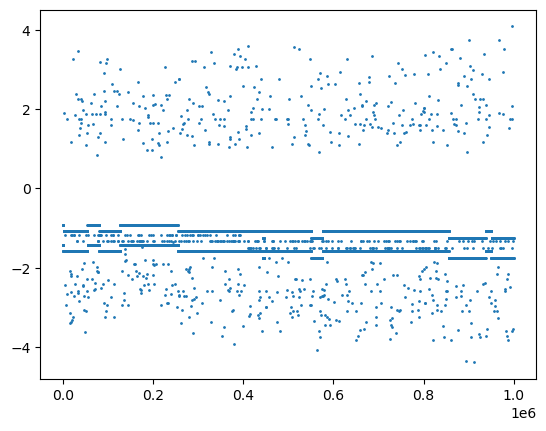

In [95]:
for day in range(1):
    plt.scatter(x=time_stamp[day], y=mid_price_diff[day], s=1)

In [ ]:
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

lag = 47
w_size = 40
new_features = []

for day in range(0, 3):
    new_features.append(np.concatenate(
        [features[day][w:-lag + w] for w in range(0, w_size)], axis=1))

new_features[1].shape
reg = make_pipeline(StandardScaler(), Lasso(alpha=0.18, max_iter=10000))
reg.fit(np.concatenate((new_features[0], new_features[1]), axis=0),
        np.concatenate((mid_price_local[0][lag:], mid_price_local[1][lag:]), axis=0))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.410e+04, tolerance: 6.859e+03
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.18, max_iter=10000))])

5598.376228030124
[ 0.          0.         -0.         ...  0.         -1.10106351
 -0.        ]


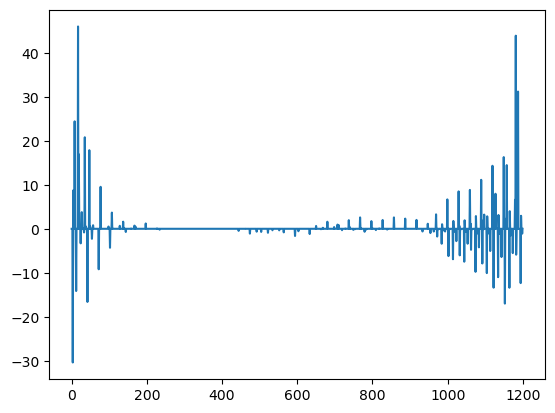

In [ ]:
print(mean_squared_error(
    mid_price_local[2][0:-lag], reg.predict(new_features[2])))
print(reg.steps[-1][1].coef_)
# print(mean_squared_error(mid_price_local[2],reg.predict(new_features[2])))
plt.plot(reg.steps[-1][1].coef_)

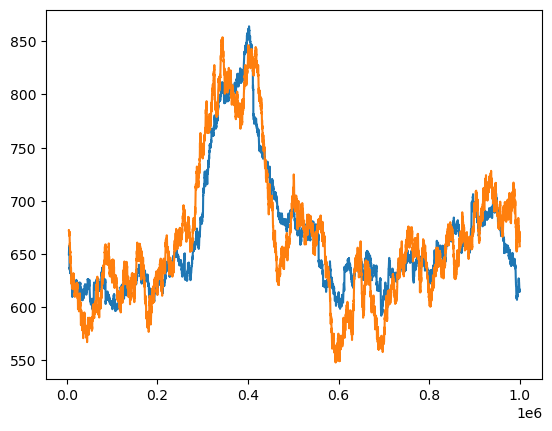

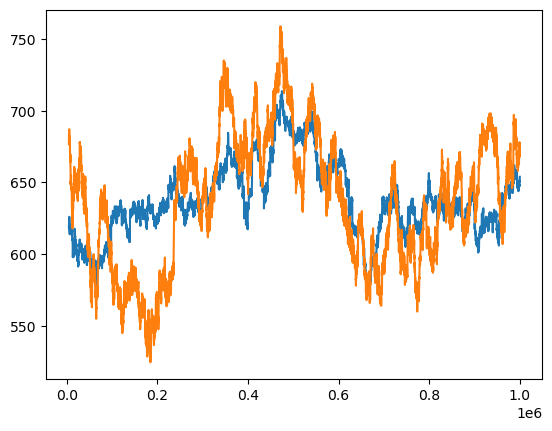

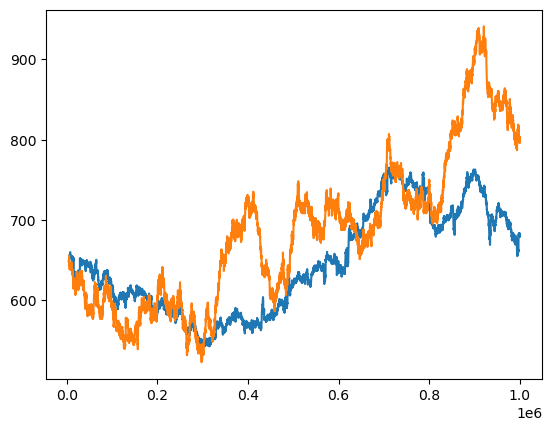

In [31]:
for day in range(0, 3):
    plt.plot(time_stamp[day][lag:], reg.predict(new_features[day]))
    plt.plot(time_stamp[day][lag:], mid_price_local[day][lag:])
    plt.show()

In [ ]:
log_price_local = [np.log(mid_price_local[day][lag:]) for day in range(0, 3)]

log_returns = [np.diff(log_price_local[day]) for day in range(0, 3)]

log_predict = [np.log(reg.predict(new_features[day])) for day in range(0, 3)]

log_diff = [log_predict[day] - log_price_local[day] for day in range(0, 3)]

In [33]:
np.corrcoef(log_diff[2][:-1], log_returns[2])

array([[1.        , 0.01570734],
       [0.01570734, 1.        ]])

In [34]:
def get_gap_df(n):
    file_name = f"./gap/gap{n}.csv"
    return pd.read_csv(file_name, sep=';')

In [ ]:
gap = [np.transpose(get_gap_df(n).to_numpy())[0] for n in range(1, 4)]

In [68]:
gap_all = np.concatenate([gap[n] for n in range(3)])

In [91]:
window_size = 30
weights = np.ones(window_size) / window_size
moving_avg = [np.convolve(gap[n], weights, mode='valid') for n in range(3)]
moving_avg_all = np.convolve(gap_all, weights, mode='valid')

In [105]:
import collections

pred_gap = []
window = collections.deque()

for i in range(len(gap_all)):
    
    if len(window) == window_size:
        window.popleft()
    window.append(gap_all[i])

    pred_gap.append(sum(window)/len(window))

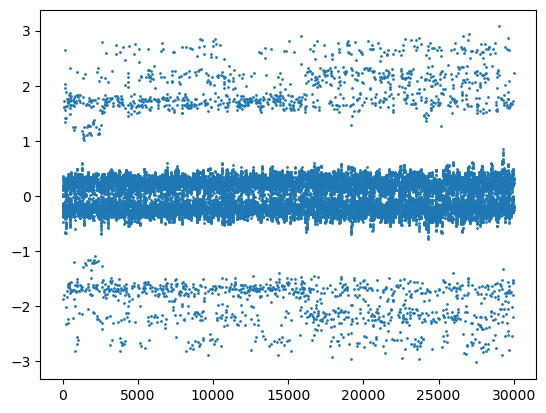

In [106]:
plt.scatter(x=np.arange(len(gap_all)),
            y=(pred_gap - gap_all), s=1)
# plt.scatter(x=np.arange(len(moving_avg_all)), y=moving_avg_all, s=1)

In [ ]:
mid_price_local_all = np.concatenate(
    [mid_price_local[day] for day in range(3)])

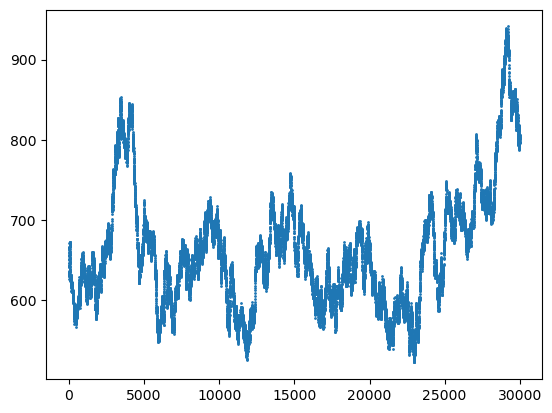

In [74]:
plt.scatter(x=np.arange(len(mid_price_local_all)), y=mid_price_local_all, s=1)

In [ ]:
def check_gbm(time_series, alpha=0.05):
    """
    Check if a time series is compatible with a geometric Brownian motion.

    Parameters:
        time_series (np.array): 1D array of prices.
        alpha (float): Significance level for hypothesis tests.

    Returns:
        dict: Dictionary of test results for normality and independence.
    """
    results = {}

    # 1. Log transform the series so that: X_t = log(S_t)
    log_series = np.log(time_series)

    # 2. Compute the log returns (increments): ΔX_t = X_t+Δt - X_t
    log_returns = np.diff(log_series)

    # 3. Test for normality
    #    a. Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(log_returns)
    results['Shapiro-Wilk'] = {'statistic': shapiro_stat, 'p-value': shapiro_p,
                               'normality': shapiro_p > alpha}

    #    b. Jarque-Bera test
    jb_stat, jb_p = jarque_bera(log_returns)
    results['Jarque-Bera'] = {'statistic': jb_stat, 'p-value': jb_p,
                              'normality': jb_p > alpha}

    # 4. Test for independence (no autocorrelation) using the Ljung-Box test
    #    Here we test at a fixed lag (e.g., 10). Adjust lags as needed.
    lb_test = acorr_ljungbox(log_returns, lags=[50], return_df=True)
    lb_p_value = lb_test['lb_pvalue'].iloc[-1]
    results['Ljung-Box'] = {'lag': 50, 'p-value': lb_p_value,
                            'independence': lb_p_value > alpha}

    # 5. Diagnostic plots
    #    a. QQ-plot to assess normality
    sm.qqplot(log_returns, line='45', fit=True)
    plt.title('QQ-Plot of Log Returns')
    plt.show()

    #    b. Histogram with fitted normal distribution
    plt.hist(log_returns, bins=30, density=True,
             alpha=0.6, color='skyblue', edgecolor='k')
    mu, sigma = np.mean(log_returns), np.std(log_returns)
    x_vals = np.linspace(log_returns.min(), log_returns.max(), 100)
    plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r', lw=2)
    plt.title('Histogram of Log Returns')
    plt.xlabel('Log Return')
    plt.ylabel('Density')
    plt.show()

    return results

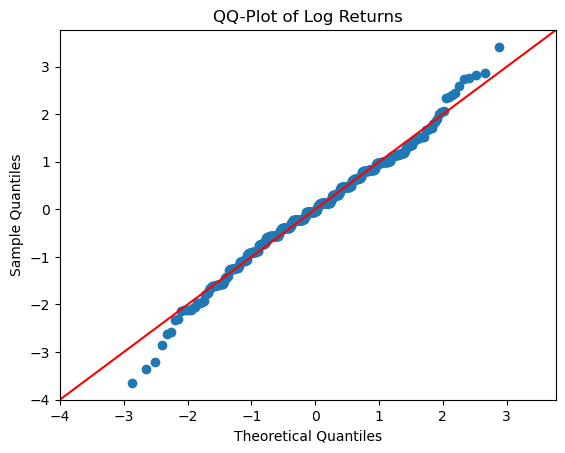

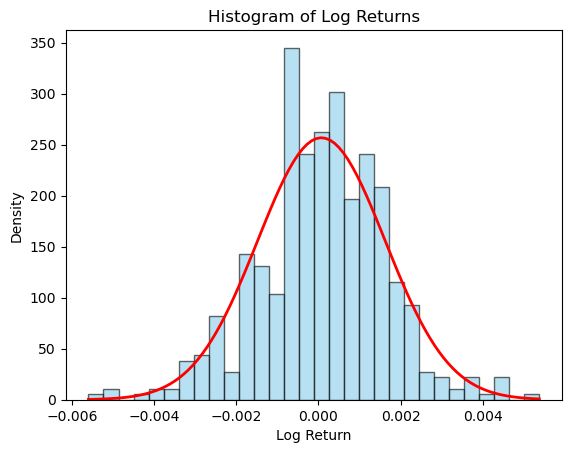

Shapiro-Wilk: {'statistic': 0.9902500655305488, 'p-value': 0.002181504155263035, 'normality': False}
Jarque-Bera: {'statistic': 15.527547225377843, 'p-value': 0.0004248503313091213, 'normality': False}
Ljung-Box: {'lag': 50, 'p-value': 0.5663546097883705, 'independence': True}


In [ ]:
day1_product_df['adj_mid_price'] = day1_product_df.apply(
    calc_adj_mid_price_2, axis=1)

# day1_product_df.plot(x='timestamp',y='mid_price')
# day1_product_df.plot(x='timestamp',y='adj_mid_price')
# plt.show()

mid_pirce_series = day1_product_df['adj_mid_price'].to_numpy()
# plt.plot(np.diff(np.log(mid_pirce_series)))

test_results = check_gbm(mid_pirce_series[5000:5500])
for test, res in test_results.items():
    print(f"{test}: {res}")

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9999.
  res = hypotest_fun_out(*samples, **kwds)


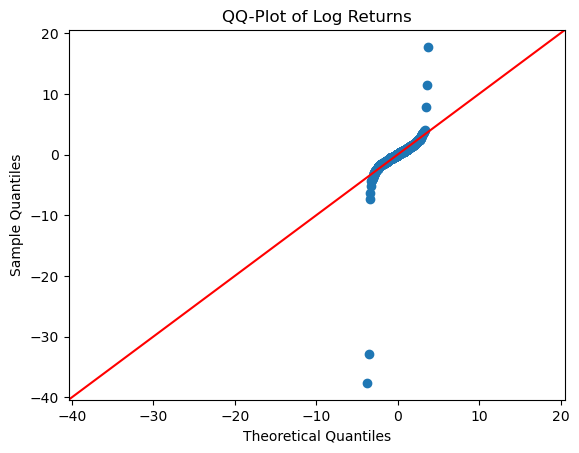

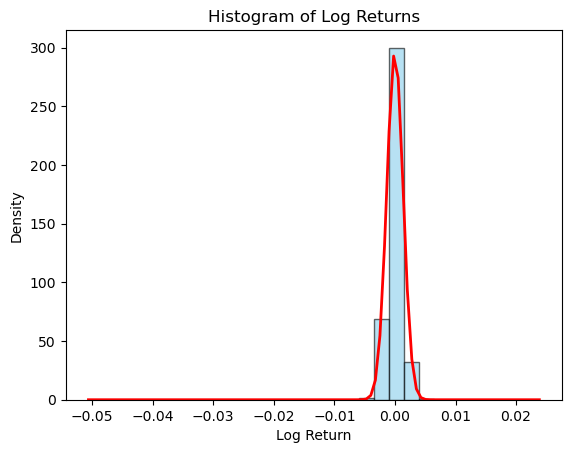

Shapiro-Wilk: {'statistic': 0.7528815080689434, 'p-value': 3.45772469018647e-81, 'normality': False}
Jarque-Bera: {'statistic': 45349767.126871504, 'p-value': 0.0, 'normality': False}
Ljung-Box: {'lag': 50, 'p-value': 3.056958573396282e-45, 'independence': False}


In [ ]:
day1_product_df['adj_mid_price'] = day1_product_df.apply(
    calc_adj_mid_price_2, axis=1)

# day1_product_df.plot(x='timestamp',y='mid_price')
# day1_product_df.plot(x='timestamp',y='adj_mid_price')
# plt.show()

mid_pirce_series = day1_product_df['adj_mid_price'].to_numpy()
return_series = np.diff(mid_pirce_series)
Log_price_series = log_series = np.log(mid_pirce_series)
log_return_series = np.diff(Log_price_series)
# plt.plot(np.diff(np.log(mid_pirce_series)))

test_results = check_gbm(mid_pirce_series[:])
for test, res in test_results.items():
    print(f"{test}: {res}")

In [ ]:
def calc_markov(time_series, scaling_factor=200):
    markov_trans_mat = np.zeros((int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1,
                                 int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1))
    markov_freq_mat = np.zeros((int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1,
                                int(max(time_series) * scaling_factor) - int(min(time_series) * scaling_factor) + 1))

    for i in range(len(time_series) - 1):
        state_now = int(time_series[i] * scaling_factor) - \
            int(min(time_series) * scaling_factor)
        state_next = int(time_series[i + 1] * scaling_factor) - \
            int(min(time_series) * scaling_factor)
        markov_freq_mat[state_now][state_next] += 1

    markov_trans_mat = markov_freq_mat / (1.0 + i)

    return markov_trans_mat, markov_freq_mat

In [ ]:
markov_trans_mat, markov_freq_mat = calc_markov(return_series[3000:], 1)

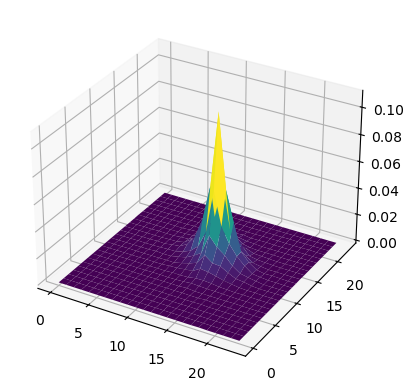

In [ ]:
x, y = np.meshgrid(np.arange(markov_trans_mat.shape[1]), np.arange(
    markov_trans_mat.shape[0]))

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, markov_trans_mat, cmap='viridis')

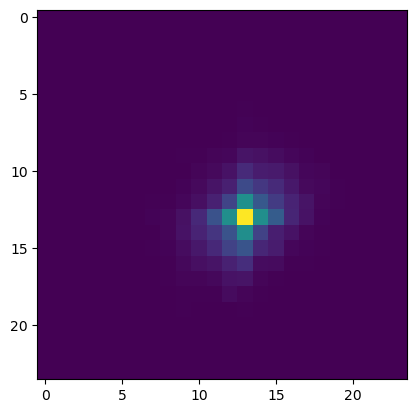

In [ ]:
plt.imshow(markov_trans_mat)

In [ ]:
def autocorrelation(series: np.array, lags):
    # 计算lags阶以内的自相关系数，返回lags个值，分别计算序列均值，标准差
    n = len(series)
    result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]
              / (series[i:].std()*series[:n-i].std()*(n-i))
              for i in range(1, lags+1)]
    return result

/var/folders/pp/zmh040gd59nfqh2pw782lv3m0000gn/T/ipykernel_44076/3768854152.py:4: RuntimeWarning: invalid value encountered in scalar divide
  result = [np.correlate(series[i:]-series[i:].mean(), series[:n-i]-series[:n-i].mean())[0]


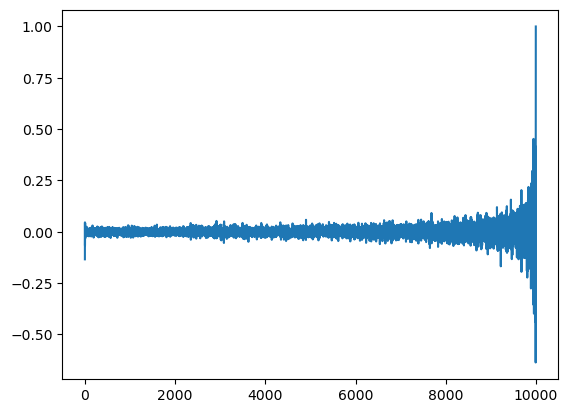

In [ ]:
plt.plot(autocorrelation(log_return_series, len(log_return_series) - 1))